<a href="https://colab.research.google.com/github/UendiMagilaj/Exam2025/blob/main/Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-13-62abf91a2cec>:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  sk.io.imshow(IC)
<ipython-input-13-62abf91a2cec>:6: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  sk.io.show()


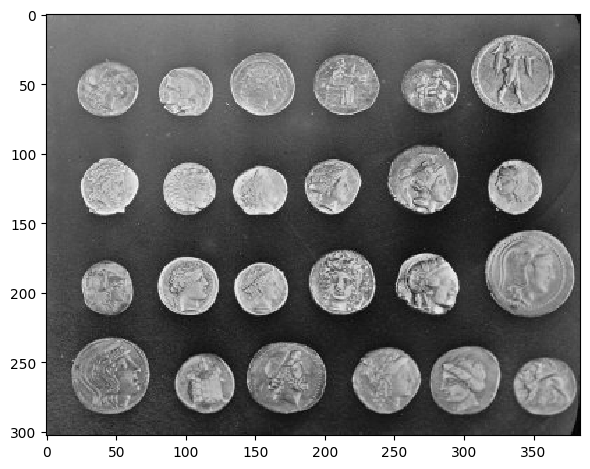

Image shape: (303, 384)
Total number of pixels: 116352
Min pixel value: 1
Max pixel value: 252


np.uint8(252)

In [13]:
#1
import skimage as sk

IC = sk.data.coins()
sk.io.imshow(IC)
sk.io.show()
print("Image shape:", IC.shape)
print("Total number of pixels:", IC.size)

print("Min pixel value:", IC.min())
print("Max pixel value:", IC.max())




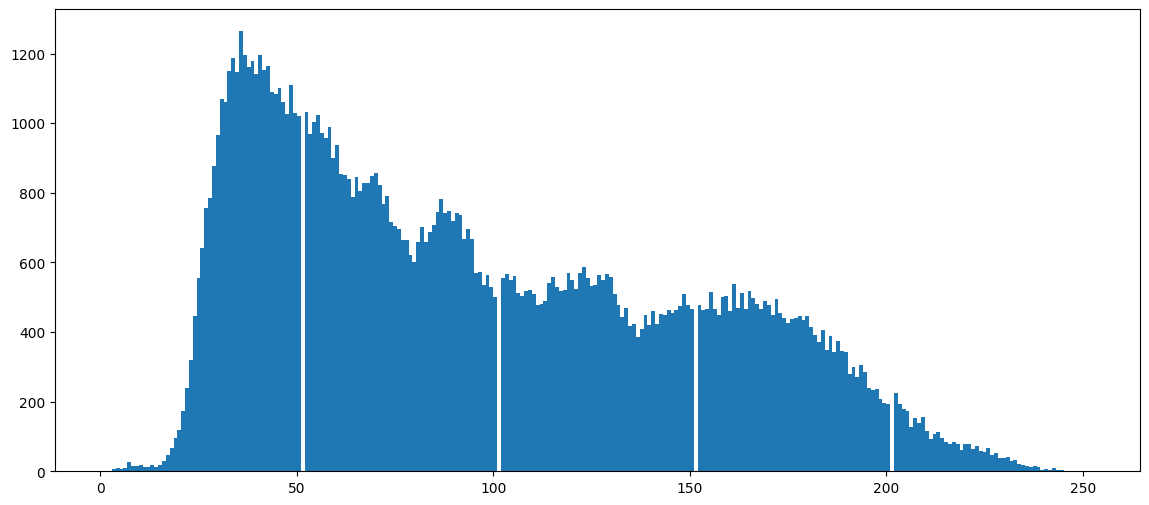

In [15]:
#2
import matplotlib.pyplot as plt
import numpy as np

v = IC.reshape(IC.shape[0]*IC.shape[1],1)

fig = plt.figure(figsize=(14, 6))
plt.hist(v, bins=256,density=False)
plt.show()

# 0–50: strong low-intensity peak → dark areas and shadows
# 50–100: mid-low peak → soft shadows and darker regions of coins
# 100–150: mid-high peak → coin surfaces reflecting moderate light
# 150–200: high peak → bright edges and highlights
# 200–255: narrow peak → strongest highlights and bright spots

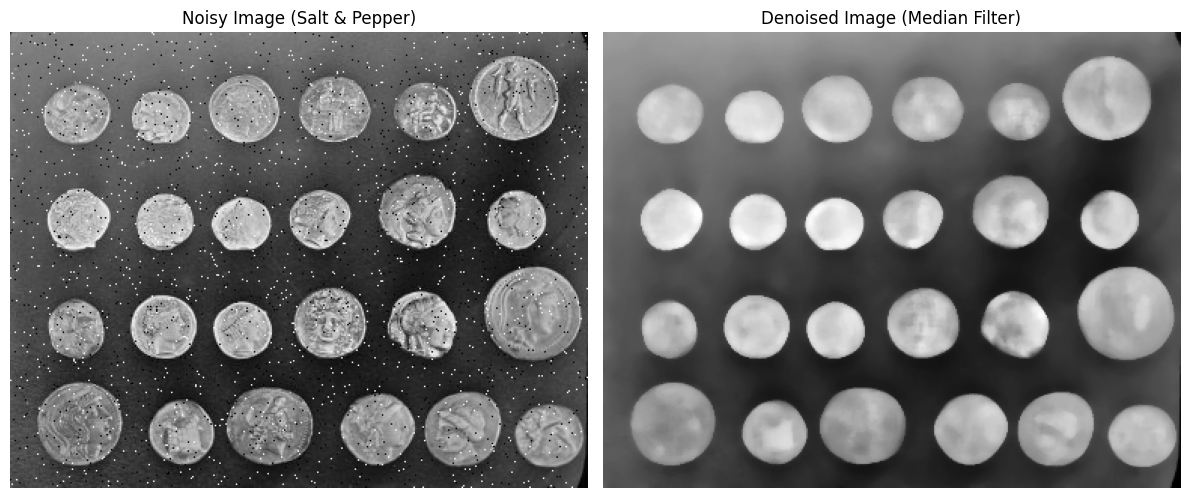

In [17]:
#3
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import median

#adding S&P noise
noise = np.random.random(IC.shape)
noisy_image = img_as_ubyte(data.coins())
noisy_image[noise > 0.99] = 255
noisy_image[noise < 0.01] = 0

#removing noise using the median filter technique
img = img_as_ubyte(noisy_image)
sel5 = disk(5)
img_med5x5 = median(img, sel5)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap='gray')
ax[0].set_title('Noisy Image (Salt & Pepper)')
ax[0].axis('off')

ax[1].imshow(img_med5x5, cmap='gray')
ax[1].set_title('Denoised Image (Median Filter)')
ax[1].axis('off')

plt.tight_layout()
plt.show()



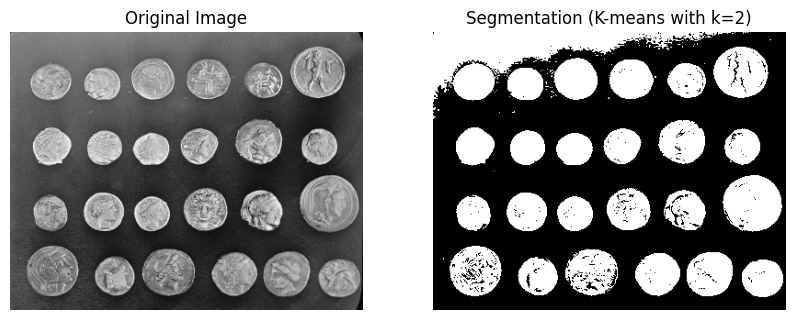

In [22]:
#4
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import numpy as np


v_I = IC.reshape(-1, 1)
n_clus = 2
kmeans = KMeans(n_clusters=n_clus, random_state=0).fit(v_I)

v_kmeans = kmeans.predict(v_I)
I_kmeans = np.reshape(v_kmeans,(IC.shape[0],IC.shape[1]))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(IC, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Segmentation (K-means with k={})'.format(n_clus))
ax2.set_axis_off()

plt.show()

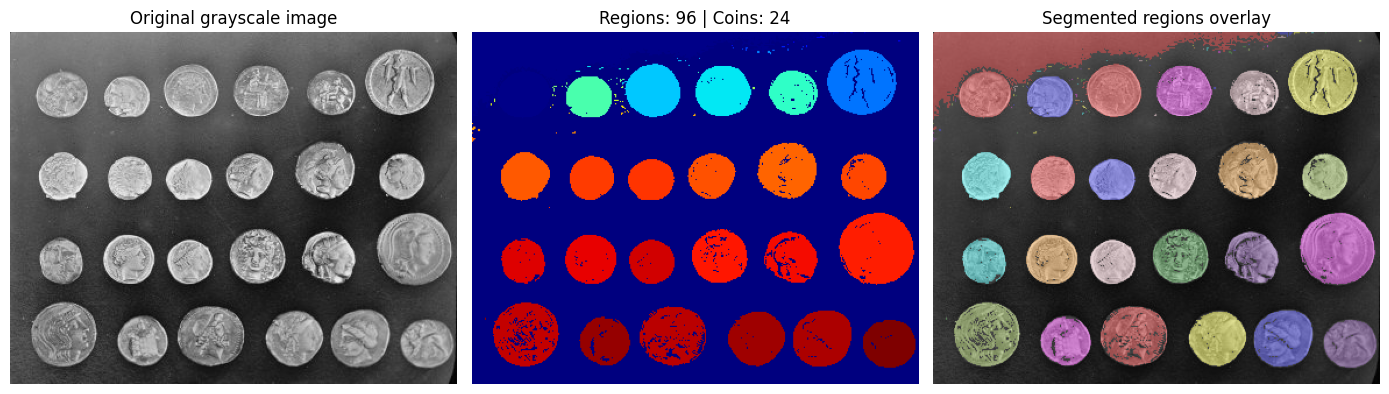

In [28]:
#5
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np

IG = IC.squeeze()
thresh = threshold_otsu(IG)
bw = IG > thresh

label_image, nregions = label(bw, return_num=True)
image_label_overlay = label2rgb(label_image, image=IG)

props = regionprops(label_image)
min_area = 450
ncoins = sum([1 for p in props if p.area >= min_area])

fig, axes = plt.subplots(1, 3, figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG, cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[0].set_axis_off()

ax[1].imshow(label_image, cmap=plt.cm.jet)
ax[1].set_title('Regions: {} | Coins: {}'.format(nregions, ncoins))
ax[1].set_axis_off()

ax[2].imshow(image_label_overlay, cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')
ax[2].set_axis_off()

plt.tight_layout()
plt.show()

In [31]:
#6
import pandas as pd
import seaborn as sns
from skimage.measure import regionprops_table

props = regionprops_table(label_image, properties=['label', 'area', 'orientation', 'axis_major_length'])
df_features = pd.DataFrame(props)
df_features.head()

,label,area,orientation,axis_major_length
0,1,8792.0,-1.423583,292.106573
1,2,37.0,1.524098,14.020584
2,3,21.0,-1.508404,16.645960
3,4,1.0,-0.785398,0.000000
4,5,2.0,0.000000,2.000000


In [32]:
#7
print('Average area: {:.2f}'.format(df_features['area'].mean()))
print('Average major axis length: {:.2f}'.format(df_features['axis_major_length'].mean()))
print('Average orientation: {:.2f} degrees'.format(df_features['orientation'].mean()))

Average area: 469.97
Average major axis length: 15.76
Average orientation: -0.16 degrees


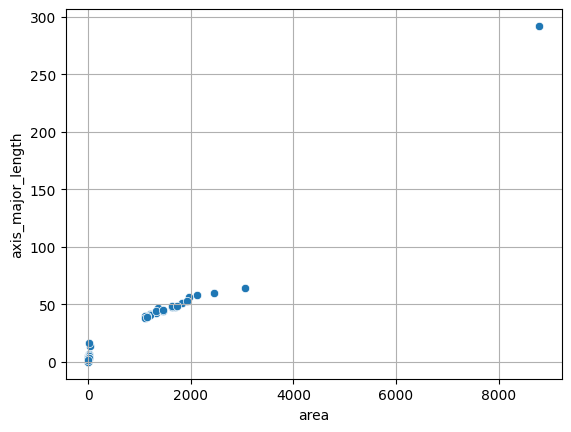

In [33]:
sns.scatterplot(x='area', y='axis_major_length', data=df_features)
plt.grid(True)
plt.show()

In [34]:
df_large_coins = df_features.loc[df_features['area'] > 1750]
df_large_coins.head()
print('Number of coins with area > 1750 pixels is {}'.format(df_large_coins.shape[0]))

Number of coins with area > 1750 pixels is 7


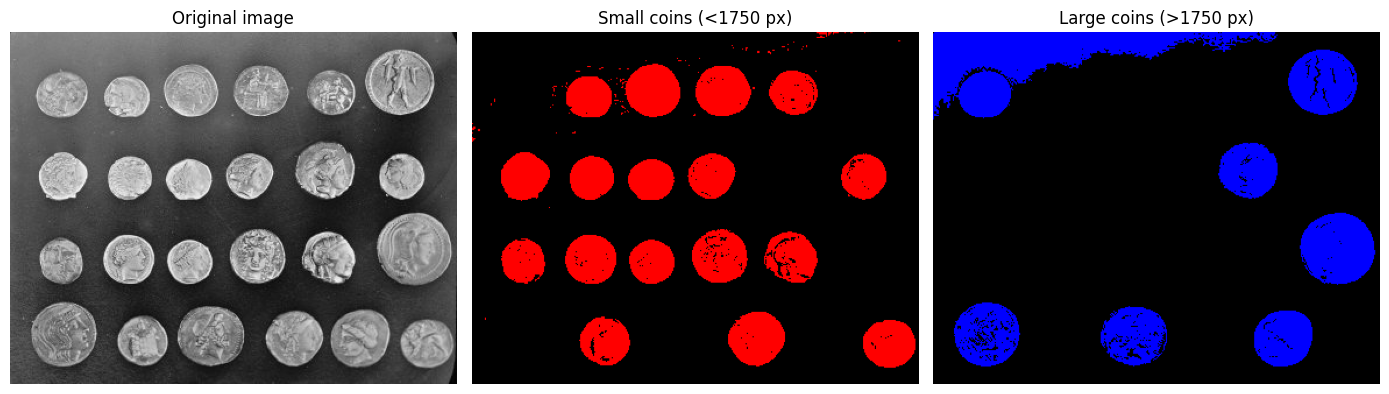

In [36]:
#8
df_small_coins = df_features[df_features['area'] < 1750]
df_large_coins = df_features[df_features['area'] > 1750]
labels_small = df_small_coins['label'].values
labels_large = df_large_coins['label'].values

mask_small = np.isin(label_image, labels_small)
mask_large = np.isin(label_image, labels_large)
rgb_small = np.zeros((*label_image.shape, 3), dtype=np.uint8)
rgb_large = np.zeros((*label_image.shape, 3), dtype=np.uint8)
rgb_small[mask_small] = [255, 0, 0]
rgb_large[mask_large] = [0, 0, 255]

fig, axes = plt.subplots(1, 3, figsize=(14, 9))
ax = axes.ravel()

ax[0].imshow(IG, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(rgb_small)
ax[1].set_title('Small coins (<1750 px)')

ax[2].imshow(rgb_large)
ax[2].set_title('Large coins (>1750 px)')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.tight_layout()
plt.show()

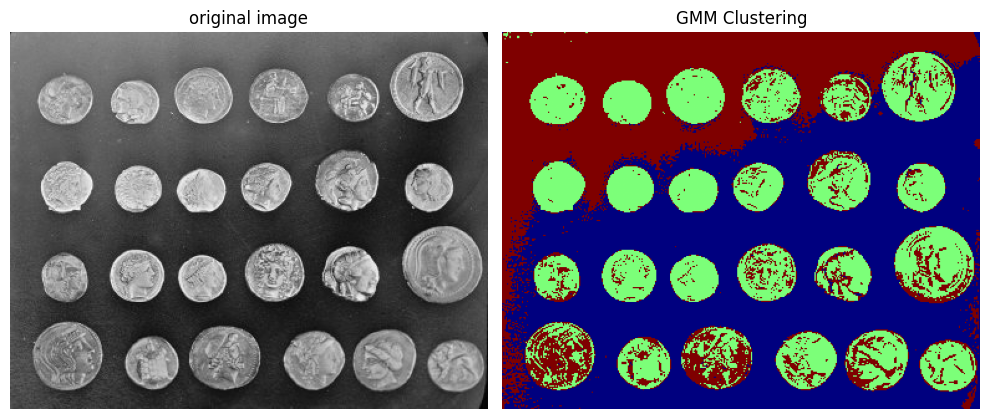

In [43]:
#9
from sklearn import mixture

height, width = IC.shape
v_I = IC.reshape((-1, 1))

gmm = mixture.GaussianMixture(n_components=3, random_state=0).fit(v_I)
v_gmm = gmm.predict(v_I)
I_gmm = np.reshape(v_gmm, (height, width))

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(IC, cmap='gray')
ax0.set_title('original image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(I_gmm, cmap='jet')
ax1.set_title('GMM Clustering')
ax1.set_axis_off()

plt.tight_layout()
plt.show()

#using GMM, we first process the image by reshaping it into a 2D array.
#for grayscale, the shape is (nr of pixels, 1) and for rgb id (nr of pixels, 3)
#then a gmm is fitted by specifying the number of clusters, and then we predict
#cluster labels for each pixel. these labels are reshaped back to the original
#image size to create a segmented output.
#when applied, both separate the coins from the background. kmeans provides
#a fast and clear segmentation based on intensity. gmm produces smoother results
#by modeling pixel intensities with probability, capturing the coin edges
#more accurately. gmm might be slower, but it's more precise


In [46]:
#10
import numpy as np
from skimage import data, img_as_ubyte
from skimage.feature.texture import graycomatrix, graycoprops

IG = img_as_ubyte(IC)
glcm = graycomatrix(IG, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

print("Texture features for the entire image:")
print(f"Contrast: {contrast:.4f}")
print(f"Dissimilarity: {dissimilarity:.4f}")
print(f"Homogeneity: {homogeneity:.4f}")
print(f"Energy: {energy:.4f}")
print(f"Correlation: {correlation:.4f}")

Texture features for the entire image:
Contrast: 351.8455
Dissimilarity: 9.2926
Homogeneity: 0.2382
Energy: 0.0196
Correlation: 0.9372


In [ ]:
#Personal discussion
#This course was really straightforward and easy to follow. I liked that the professor went straight into
#explaining the exercises. That made it easier to stay focused and understand the concepts as we applied them.
#This course helped me understand key concepts like image preprocessing and image segmentation that i had encountered before in my bachelor studies,
#but working directly with images helped me understand how these tools work in real situations.
#Thank you for the great course!